# 1.객체 추적 알고리즘
- 움직이는 객체 식별하고 위치 추적하는 방법
- 객체의 히스토그램을 기반으로 추적하는 알고리즘
- 초기위치 선택, 해당위치 픽셀 분포를 히스토그램으로 계산
- 히스토그램 유사도 측정하여 객체의 새로운 위치 찾음
- 과정 반복하여 객체 움직임 추적

>## 1) 평균이동추적 실습

>>### (1) VS Code Teminal 창에 OpenCV 설치

>> 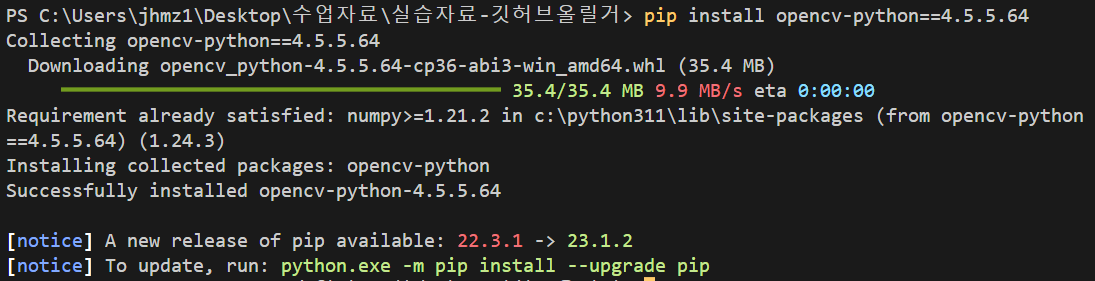

In [ ]:
pip install opencv-python==4.5.5.64

>>### (2) 평균이동 추적 위한 초기 사각형 설정

In [ ]:
#추적할 객체의 위치정보 저장 변수
tracking_window = None

#추적할 객체의 히스토그램 저장할 변수
roi_hist = None

#평균 이동 알고리즘 수렴 기준 설정
#EPS : 수렴조건 - 이전위치와 현재위치의 이동 벡터크기 최소 변경값
#COUNT : 수렴조건 - 최대반복횟수 (10:10번반복후 수렴안하면 알고리즘 정지 / 1:수렴조건판단최소값)
trem_cri = (cv2.TERM_CRITERIA_EPS | cv2.TermCriteria_COUNT, 10, 1)  

>>### (3) 동영상 파일 열기

In [ ]:
cap = cv2.VideoCapture("slow_traffic_small.mp4")

>>### (4) 첫 프레임에서 추적할 객체 선택

In [ ]:
#첫 프레임에서 추적할 객체 선택
ret, frame = cap.read()
x, y, w, h = cv2.selectROI("selectObject", frame, False, False)
#print("선택한 박스 좌표 : ", x, y, w, h)

>>>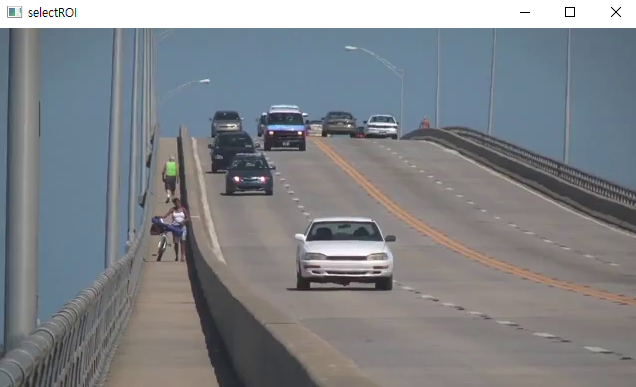

>>### (5) 추적할 객체의 초기 히스토그램 계산 

In [ ]:
#선택한 좌표와 너비 사용해 해당 객체 추출하여 roi변수에 저장
roi = frame[y:y+h, x:x+w]

# 이미지를 HSV로 변환 : 색상(Hue), 채도(Saturation), 명도(Value)로 이루어짐 
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# 이미지 채널에서 히스토그램 계산에서 roi_hist에 저장
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0,100])

# 히스토그램을 0-255 사이 범위로 정규화하여 값 조정
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

#추적할 객체의 초기 윈도우 좌표 및 크기 설정(이후 객체 위치 업데이트에 사용)
track_window = (x, y, w, h)

#결과확인
#cv2.imshow('roi test', roi)
#cv2.waitKey(0)

>>### (6) 평균 이동 추적(Mean Shift Tracking) 실습


In [ ]:
while True:
    #프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break

    #추적할 객체의 히스토그램 역투영 계산
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,100], 1)

    # 평균 이동 알고리즘 통해 객체 위치 추정
    ret, track_window = cv2.meanShift(dst, track_window, trem_cri)

    # 추적결과를 사각형으로 표시
    x, y, w, h = track_window
    print(x, y, w, h)
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)

    # 프레임 출력 
    cv2.imshow("Mean Shift Tracking", frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 자원해제
cap.release()
cv2.destroyAllWindows()

>>> 화면이 뜨면 찾고싶은 자동차 드래그 후 엔터
>>> 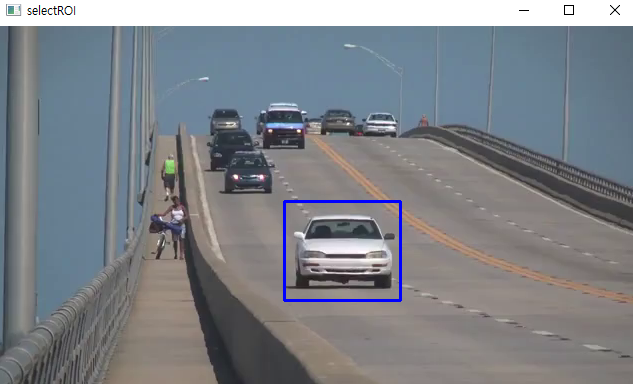

>>>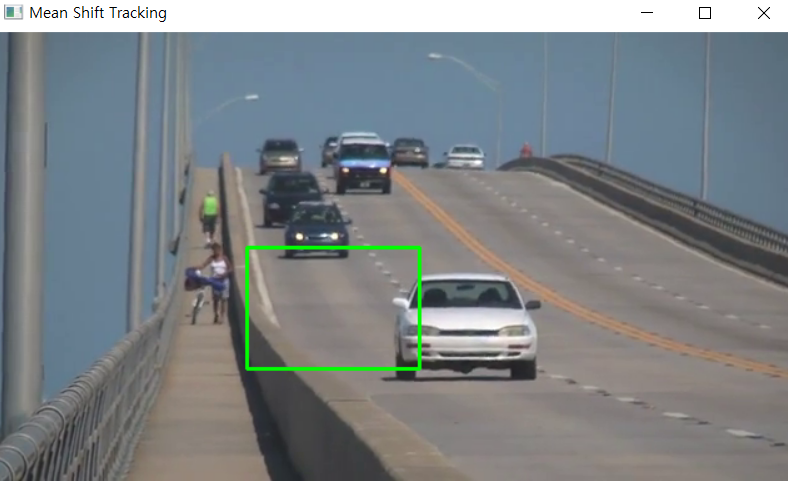

>## 2) 칼만필터 추적
>- 상태 추정에 사용되는 필터링 기술로 객체 추적에 사용
>- 초기예측과 실제 관측 기반으로 객체 위치/속도 추정함
>- 예측/관측 간 오차 고려하여 정확한 위치 업데이트 가능
>- 객체 경로 추적/예측 통해 불확실성 줄임

>>### (1) 칼만필터 초기화

>>#### 전이행렬
>>- 칼만필터에서 상대벡터의 시간에 따른 변화 나타내는 행렬
>>- 시스템이 Markov 성질 가지고 있다고 정의함
>>- 현재 상태에만 의존하고 이전 상태들과 독립적으로 변화하는 것 의미함
>>- 전이행렬 : 시스템의 동역학 모델링하고 상태 변화 표현하는데 사용

>>#### 측정행렬
>>- 칼만필터에서 측정벡터를 상태벡터로 변환하는 역할
>>- 상대벡터와 측정벡터 간의 선형 관계 나타는 행렬
>>- 2차원 측정벡터 사용시 측정행렬 : 2x4크기

In [ ]:
#칼만 필터 초기화

#칼만 필터 객체 생성(4:상태벡터크기, 2:측정벡터크기)
kalman = cv2.KalmanFilter(4,2)

#측정행렬설정 : 측정벡터를 상대 벡터로 변환 
kalman.measurementMatrix = np.array([[1,0,0,0],
                                     [0,1,0,0]], np.float32)

#전이행렬설정 : 시간에 따른 상태벡터 변화 나타냄 
kalman.transitionMatrix = np.array([[1,0,1,0],
                                    [0,1,0,1],
                                    [0,0,1,0],
                                    [0,0,0,1]], np.float32)

#프로세스 잡음 공분산을 행렬로 설정 : 시스템 불확실성 모델링
kalman.processNoiseCov = np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0],
                                   [0,0,0,1]], np.float32) * 0.05

>>### (2) 동영상 초기 추정 위치 설정

In [ ]:
#칼만 필터 추적
#동영상 파일 읽기
cap = cv2.VideoCapture("slow_traffic_small.mp4")
print(cap)

#첫 프레임에서 추적할 객체 선택
ret, frame = cap.read()
print(ret, frame)

#SelectObject 창 만들어서 객체 선택할 수 있게 만듦 
bbox_info = cv2.selectROI("select Object", frame, False, False)
print("box info:", bbox_info)

#객체 추적을 위한 초기 추정 위치 설정
kalman.statePre = np.array([[bbox_info[0]], #객체 X 좌표
                            [bbox_info[1]], #객체 Y 좌표
                            [0], [0]], #나머지 두 요소 초기화 : 객체속도 0으로 추정
                            np.float32)

>> SelectObject 창 뜨면 사진에서 자동차 부분 드래그 + Enter
>>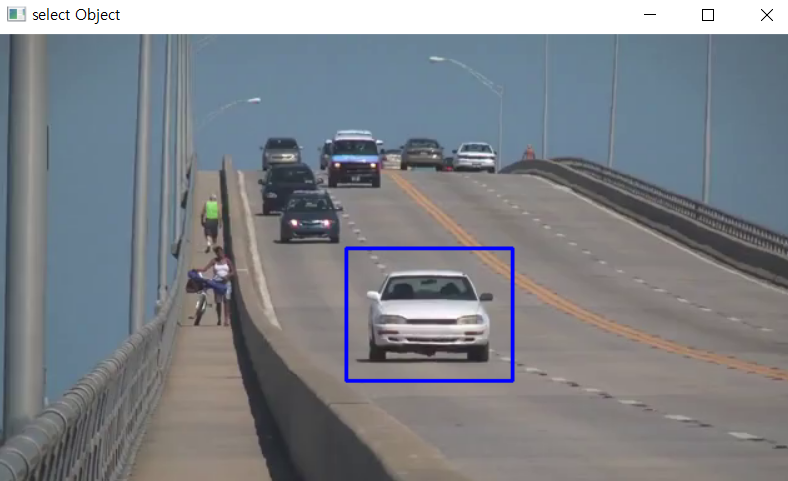

>> Terminal 창에 객체 위치 좌표 표시됨
>>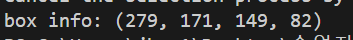

>>### (3) 객체 위치 추정

In [ ]:
#칼만 필터 추적
while True:
    #프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break

    #칼만 필터 사용하여 객체 위치 추정
    kalman.correct( #측정값 사용해서 칼만 필터 예측 보정하는 과정
        np.array([  #측정값 
            [np.float32(bbox_info[0] + bbox_info[2] /2)],
            [np.float32(bbox_info[1] + bbox_info[3] /2)]
        ])
    )
    kalman.predict()    #칼만필터 예측단계 수행 : 객체 위치 예측


    #칼만 필터로 추정된 객체 위치 
    predicted_bbox = tuple(map(int, kalman.statePost[:2,0]))

    #추정된 객체 위치를 사각형으로 표시
    cv2.rectangle(frame, 
                  (predicted_bbox[0] - bbox_info[2] // 2,
                   predicted_bbox[1] - bbox_info[3] //2),
                  (predicted_bbox[0] - bbox_info[2] // 2,
                   predicted_bbox[1] - bbox_info[3] //2),
                  (0,255,0),2)
    
    #프레임 출력
    cv2.imshow("Kalman Filter Tracking", frame)

    #'q'키를 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

#자원해제
cap.release()
cv2.destroyAllWindows()

>>>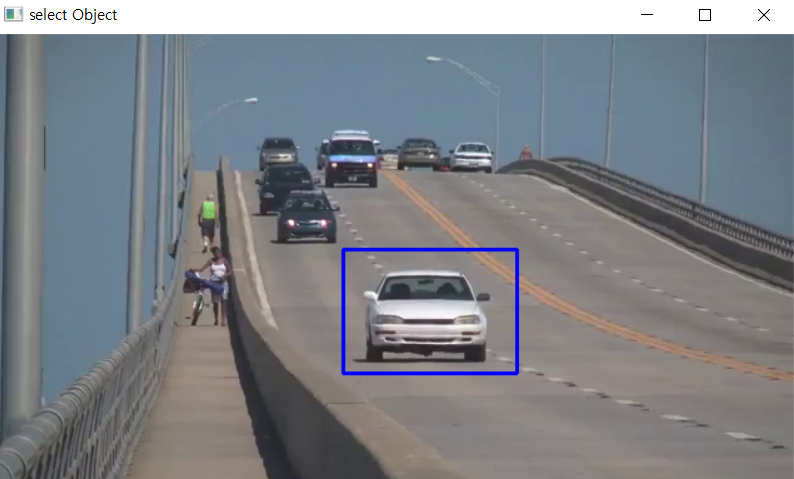
>>>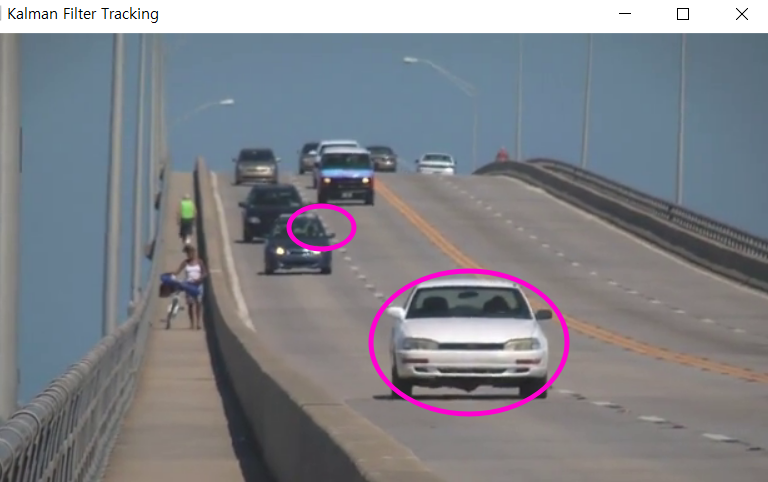

>## 3) 특징점 기반 추적
>- 특징점 기반 추적 : 객체의 특징점 추출해서 객체 추적
>- SIFT (Scale-Invariant Feature Transform), SURF (Speeded-Up Robust Features), ORB (Oriented FAST and
Rotated BRIEF) 알고리즘 사용하여 검출
>- 다음프레임에서 찾고, 매칭 통해 움직임 추적
>- 일지도와 거리 기반으로 가장 좋은 매칭 찾는 알고리즘 사용

>>### (1) 특징점 기반 추척

In [ ]:
import cv2

# 동영상 파일 열기
cap = cv2.VideoCapture("slow_traffic_small.mp4")

# Shi-Tomasi 코너 검출기 파라미터 설정
feature_params = dict(maxCorners=100,  # 검출할 최대 코너 수
                      qualityLevel=0.3,  # 코너로 간주할 최소 품질
                      minDistance=7,  # 검출된 코너 사이의 최소 거리
                      blockSize=7)  # 코너 검출을 위한 이웃 픽셀 블록 크기

# Lucas-Kanade 광학 흐름 파라미터 설정
lk_params = dict(winSize=(15, 15),  # 특징점 주변 윈도우 크기
                 maxLevel=2,  # 피라미드 레벨 수
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))  # 알고리즘 중지 기준


# 첫 프레임 읽어서 회색조 변환
ret, prev_frame = cap.read()  # 프레임 읽기 성공 여부를 나타내는 변수
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)  # 이전 프레임을 그레이스케일로 변환

# 초기 추적 지점
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)  # 추적할 특징점
prev_points = prev_corners.squeeze()  # 검출된 특징점의 좌표 지정

# 추적 결과 표시용 색상 설정
color = (0, 255, 0)


# 추적기 실행
while True:
    # 다음 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break

    # 현재 회색조 프레임 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Lucas-Kanade 광학 흐름 계산
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray, gray, prev_points, None, **lk_params)

    # 추적 결과 표시 (특징점 순회)
    for i, (prev_point, next_point) in enumerate(zip(prev_points, next_points)):
        x1, y1 = prev_point.astype(int)
        x2, y2 = next_point.astype(int)

        cv2.line(frame, (x1, y1), (x2, y2), color, 2)
        cv2.circle(frame, (x2, y2), 3, color, -1)  # 반지름 3, 원 내부 -1

    # 프레임 출력
    cv2.imshow("Feature-based Tracking", frame)

    # 다음 프레임을 위해 변수 업데이트
    prev_gray = gray.copy()  # 이전 프레임의 흑백 이미지 나타냄
    prev_points = next_points  # 이전 프레임 흑백 이미지 복사해서 좌표 업데이트

    # 'q' 키 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 자원 해제
cap.release()
cv2.destroyAllWindows()


>>>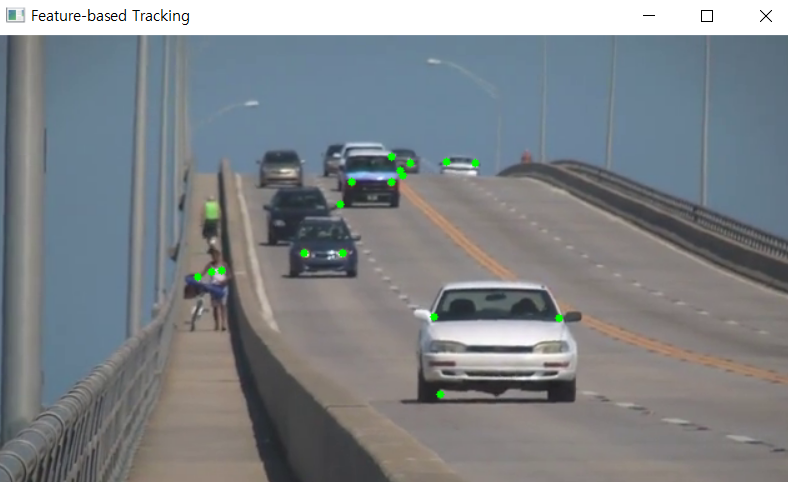

>>### (2) SIFT(Scale-Invariant Feature Transform):
>>- 크기 및 회전에 불변한 특징점 검출 및 설명 알고리즘 
>>- 다양한 크기와 회전에서 특징점 검출하고, 특징점 주변의 지역 특징을 기술 
>>- 특징점 간의 일치를 찾기 위해 특징점 기술자 사용
>>- 매우 강력한 특징점 검출/일치 알고리즘

In [ ]:

import cv2

#동영상 파일 열기
cap = cv2.VideoCapture("gorilla.mp4")

# SIFT 객체 생성
sift = cv2.SIFT_create()

while True:
    #프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break
    
    #그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #특징점 검출
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    #특징점 그리기
    frame = cv2.drawKeypoints(frame, keypoints, None, 
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    #프레임 출력
    cv2.imshow("SFIT", frame)

    #'q'키 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 자원해제
cap.release()
cv2.destroyAllWindows()

>>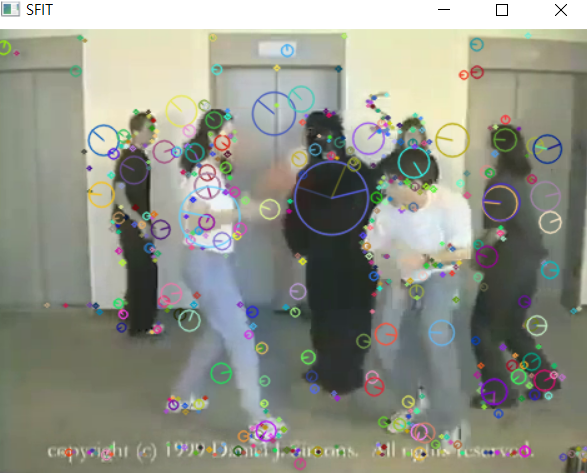
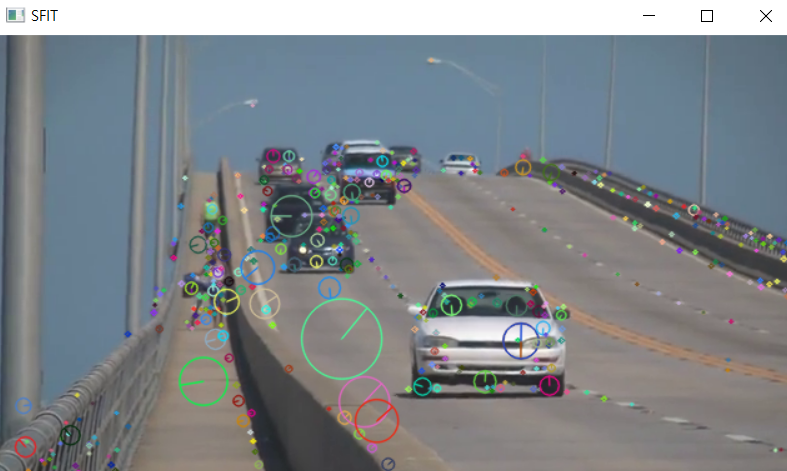

>>>### (3) SIFT - 특징점 개수 제한

In [ ]:

import cv2

#동영상 파일 열기
cap = cv2.VideoCapture("gorilla.mp4")

# SIFT 객체 생성
sift = cv2.SIFT_create(contrastThreshold=0.02)

# 특징점 개수 제한 설정
max_keypoints = 100  #원하는 최대 특징점 개수

while True:
    #프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break
    
    #그레이스케일 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #특징점 검출
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    #특징점 개수 제한 
    if len(keypoints) > max_keypoints:
        keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]

    #특징점 그리기
    frame = cv2.drawKeypoints(frame, keypoints, None, 
                              flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    #프레임 출력
    cv2.imshow("SIFT", frame)

    #'q'키 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 자원해제
cap.release()
cv2.destroyAllWindows()

>>>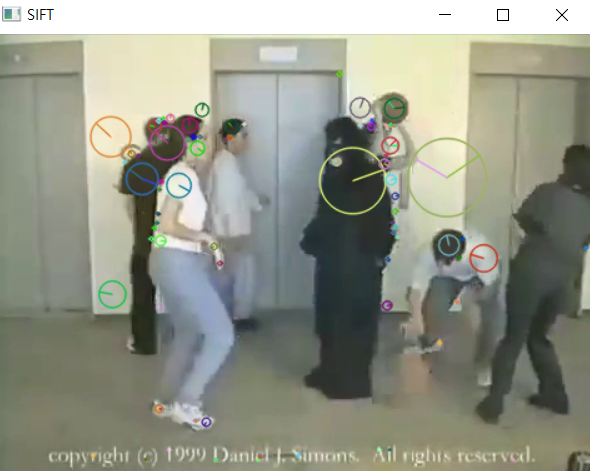

>>>### (4) SURF (speeded up robust features)
>>>- SIFT 알고리즘 개선 후 속도 높인 버전
>>>- SIFT 유사하지만 계산 속도 빠름
>>>- 특징점 검출, 기술/일치 과정에서 이미지 피라미드 및 박스 필터 사용

>>>### (5) ORB(Oriented Fast and Rotated BRIEF)
>>>- FAST 특징점 검출기 + BRIEF 기술자 조합
>>>- 빠르고, 특징점 주변의 특징 설명
>>>- 회전에 불변한 특징점 검출 및 설명 제공
>>>- ORB : SIFT, SURF 더빠르지만 덜 정확한 결과 제공

>>>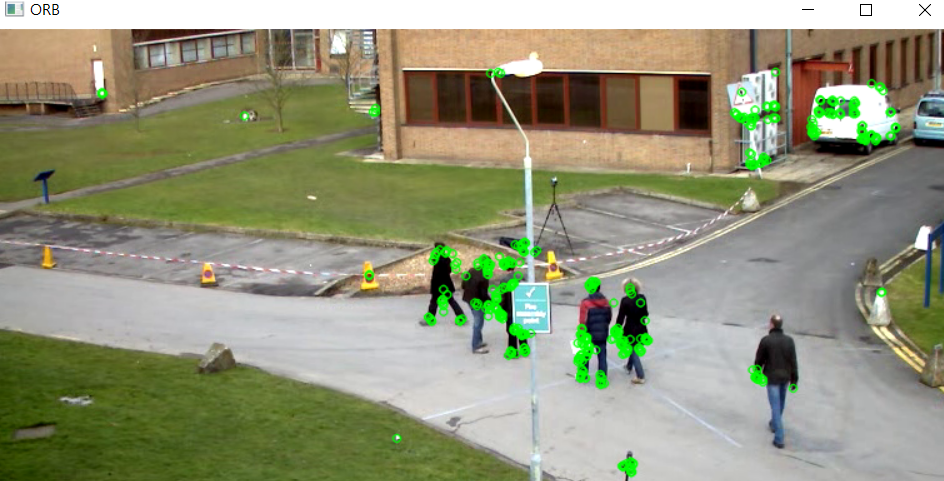

>>### (5) ORB - 중복 특징점 제거

In [ ]:
import cv2
import numpy as np

#동영상 파일 열기
cap = cv2.VideoCapture("vtest.avi")

#ORB 객체 생성
orb = cv2.ORB_create()

#특징점 최소 크기 설정
min_keypoint_size = 10

#중복 특징점 제거 기준 거리
duplicate_threshold = 10

while True:
    #프레임 읽기
    ret, frame = cap.read()
    if not ret:
        break
    
    #그레이스케일로 변환 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #특징점 검출
    keypoints = orb.detect(gray, None)

    #특징점 크기가 일정 크기 이상인 것만 남기기
    keypoints = [kp for kp in keypoints if kp.size > min_keypoint_size]

    #중복된 특징점 제거
    mask = np.ones(len(keypoints), dtype=bool)
    for i, kp1 in enumerate(keypoints):
        if mask[i]:
            for j, kp2 in enumerate(keypoints[i+1:]):
                if (
                    mask[i+j+1] 
                    and np.linalg.norm(np.array(kp1.pt)-np.array(kp2.pt)) 
                    < duplicate_threshold
                    ):
                    mask[i+j+1] = False

            keypoints = [kp for i, kp in enumerate(keypoints) if mask[i]]


    # 'q' 키를 누르면 종료
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# 자원 해제
cap.release()
cv2.destroyAllWindows()